In [4]:
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [5]:
from google.colab import userdata
hugging_face_token = userdata.get('HF_TOKEN')

# Check if the token is retrieved
if hugging_face_token:
    print("Hugging Face token has been successfully retrieved.")
else:
    print("Failed to retrieve Hugging Face token.")

Hugging Face token has been successfully retrieved.


In [6]:
from transformers import AutoTokenizer, AutoModelWithLMHead, T5Tokenizer

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [2]:
from datasets import load_dataset
dataset = load_dataset('coai/plantuml_generation')

Generating train split:   0%|          | 0/1940 [00:00<?, ? examples/s]

In [3]:
print(dataset['train'][0])

{'text': '<s>[INST]\nFor the given description, generate \na Sequence diagram diagram using plantuml. \nDescription: Use Case Name: Patient Registration\nUse Case ID: HC-001\n\nUse Case Description:\nThis use case describes the process of registering a new patient in a healthcare system.\n\nUse Case Actors:\n1. Front desk staff\n2. Patient\n\nUse Case Triggers:\n- A new patient arrives at the healthcare facility and wants to register.\n\nUse Case Preconditions:\n- The patient has not been registered in the system before.\n- The front desk staff is available to assist the patient.\n\nUse Case Postconditions:\n- The patient\'s information is recorded in the healthcare system.\n- The patient is assigned a unique identification number.\n\nUse Case Flow:\n1. The patient approaches the front desk and expresses the intention to register.\n2. The front desk staff welcomes the patient and requests basic information such as name, date of birth, address, contact number, and insurance details.\n3.

In [7]:
import torch
import json

In [8]:
device = torch.device('cuda')

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

#device = torch.device('cpu')

# Import the data
data_import = load_dataset("coai/plantuml_generation")

def prepare_input(input_data):
    # Corrected regex to escape the pipe character
    segments = re.sub(r'|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    # Extracting description and PlantUML code
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': segments[1].strip()
    }

# Prepare the data array
prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

# Create a DataFrame from the prepared data array
data_frame = pd.DataFrame(prepared_data_array)

# Split the data into training and validation sets
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)


# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-large')

# Add special tokens to the tokenizer (if any)
#special_tokens_dict = {'additional_special_tokens': ['</s>']}
#num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

# Resize model's token embeddings to fit the additional special tokens
#model.resize_token_embeddings(len(tokenizer))

# Prepare the data for T5
def prepare_data_for_t5(batch):
    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=512)
    outputs = tokenizer(batch['plantUML_code'], padding='max_length', truncation=True, max_length=512)
    inputs['labels'] = outputs['input_ids']
    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.795400,0.860468
2,0.815000,0.618761
3,0.534700,0.542337
4,0.439100,0.512237
5,0.366200,0.491806
6,0.380200,0.483649
7,0.329800,0.473360
8,0.277500,0.479810
9,0.296600,0.485293
10,0.221400,0.489684


KeyboardInterrupt: 

In [ ]:
model.push_to_hub("debusaha/t5-large_plantUML", token = HF_TOKEN)
tokenizer.push_to_hub("debusaha/t5-large_plantUML", token = HF_TOKEN)

KeyboardInterrupt: 

In [ ]:
# Function to perform inference
def generate_plantuml_code(model, tokenizer, device, description, max_length=512):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return plantuml_code

# Example description for inference
example_description = "Your description here."

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=512)

# Print the generated PlantUML code
print(plantuml_code_generated)

Your description here. Your description here.


In [ ]:
# Function to perform inference
def generate_plantuml_code(model, tokenizer, device, description, max_length=512):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return plantuml_code

# Iterate over the descriptions in val_df and generate PlantUML code
for index, row in val_df.iterrows():
    description = row['description']
    plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, description, max_length=512)
    print(f"Description: {description}\nGenerated PlantUML Code:\n{plantuml_code_generated}\n")


Description: <s>
For the given description, generate 
a Usecase diagram diagram using plantuml. 
Description: Use Case Name: Passenger Check-in System
Use Case ID: UC001

Use Case Description:
The Passenger Check-in System allows passengers to check-in for their flights and complete the necessary procedures before boarding.

Use Case Actors:
- Passenger: The person who is checking in for their flight.

Use Case Triggers:
- The passenger arrives at the airport for their scheduled flight.

Use Case Preconditions:
- The passenger has a valid flight reservation.
- The passenger has all the necessary travel documents.
- The passenger has arrived at the airport within the specified check-in time.

Use Case Postconditions:
- The passenger is successfully checked-in for their flight.
- The passenger receives their boarding pass.

Use Case Flow:
1. The passenger approaches the check-in counter.
2. The system prompts the passenger to provide their flight reservation details, such as the booking 

KeyboardInterrupt: 

In [ ]:
def generate_plantuml_code(model, tokenizer, device, description, max_length=512):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Get the end-of-sequence token id for '@enduml'
    eos_token_id = tokenizer.encode('@enduml', add_special_tokens=False)[0]

    # Generate the output token ids with a specified max_length and eos_token_id
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length, eos_token_id=eos_token_id)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return plantuml_code

# Example description for inference
example_description = val_df['description'].iloc[0]

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=512)

# Print the generated PlantUML code
print(plantuml_code_generated)


@


In [ ]:
def generate_plantuml_code(model, tokenizer, device, description, max_length=1024):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Manually truncate the output after '@enduml'
    end_index = plantuml_code.find('@enduml')
    if end_index != -1:
        plantuml_code = plantuml_code[:end_index + len('@enduml')]

    return plantuml_code

# Example description for inference
example_description = val_df['description'].iloc[15]

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=512)

# Print the generated PlantUML code
print(plantuml_code_generated)


@startuml [*] --> UserAccessesPlatform UserAccessesPlatform --> UserLogsIn UserLogsIn --> RequestServiceSection UserSelectsServiceType --> RequestServiceSection : selects service type RequestServiceSection --> ServiceRequestDetails : provides service description ServiceRequestDetails --> ServiceAppointment : selects service date and time ServiceAppointment --> UserRequest : provides service request details UserReviews request details and confirms request ServiceProviders --> ServiceProviders : sends confirmation email to service request details ServiceProviders --> ReviewRequest : reviews service request and respond with availability and cost estimates ServiceProviderRequest --> ServiceRequest : review service request and respond with availability and cost estimates ServiceRequest --> User : selects service provider User --> ServiceProvider : selects service provider ServiceRequest based on availability and cost ServiceProvider --> User : finalizes service appointment ServiceProvider -

In [17]:
import graphviz

In [18]:
!pip install plantuml

In [19]:
import plantuml

In [ ]:
plantuml_code = """
@startuml UserSelectsServiceType --> RequestServiceSection : selects service type
 RequestServiceSection --> ServiceRequestDetails : provides service description
  ServiceRequestDetails --> ServiceAppointment : selects service date and time\n ServiceAppointment --> UserRequest : provides service request details UserReviews request details and confirms request\n  @enduml
"""
# Write the PlantUML code to a file
with open('diagram.puml', 'w') as file:
    file.write(plantuml_code)

In [ ]:
from plantuml import PlantUML

# Create a PlantUML instance pointing to the local PlantUML server
plantuml = PlantUML(url='http://www.plantuml.com/plantuml/img/')

# Generate the diagram
plantuml.processes_file('diagram.puml')

In [ ]:
from IPython.display import Image, display

# Display the generated diagram
display(Image(filename='diagram.png'))

In [ ]:
import subprocess

# Your PlantUML code
plantuml_code = """
@startuml
Alice -> Bob: Authentication Request
Bob --> Alice: Authentication Response
@enduml
"""

# Write the PlantUML code to a file
with open('diagram.puml', 'w') as file:
    file.write(plantuml_code)

# Call the PlantUML command-line tool to generate the diagram
subprocess.run(['plantuml', '-tpng', 'diagram.puml'])

# Display the generated diagram
from IPython.display import Image, display
display(Image(filename='diagram.png'))


FileNotFoundError: [Errno 2] No such file or directory: 'plantuml'

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt

# Import the data
data_import = load_dataset("coai/plantuml_generation")

def prepare_input(input_data):
    # Corrected regex to escape the pipe character
    segments = re.sub(r'\|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    # Extracting description and PlantUML code
    # The PlantUML code should already contain the correct newlines, so no need to replace spaces with newlines
    plantUML_code_with_newlines = segments[1].strip()
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': plantUML_code_with_newlines
    }


# Prepare the data array
prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

In [ ]:
print(prepared_data_array[0])

{'description': "<s>\nFor the given description, generate \na Sequence diagram diagram using plantuml. \nDescription: Use Case Name: Patient Registration\nUse Case ID: HC-001\n\nUse Case Description:\nThis use case describes the process of registering a new patient in a healthcare system.\n\nUse Case Actors:\n1. Front desk staff\n2. Patient\n\nUse Case Triggers:\n- A new patient arrives at the healthcare facility and wants to register.\n\nUse Case Preconditions:\n- The patient has not been registered in the system before.\n- The front desk staff is available to assist the patient.\n\nUse Case Postconditions:\n- The patient's information is recorded in the healthcare system.\n- The patient is assigned a unique identification number.\n\nUse Case Flow:\n1. The patient approaches the front desk and expresses the intention to register.\n2. The front desk staff welcomes the patient and requests basic information such as name, date of birth, address, contact number, and insurance details.\n3.

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.789600,0.853637
2,0.820700,0.616045
3,0.541300,0.546050
4,0.434900,0.510647
5,0.373100,0.490901
6,0.387500,0.486681
7,0.350200,0.481132
8,0.314000,0.481418
9,0.346200,0.485095
10,0.255900,0.486630


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


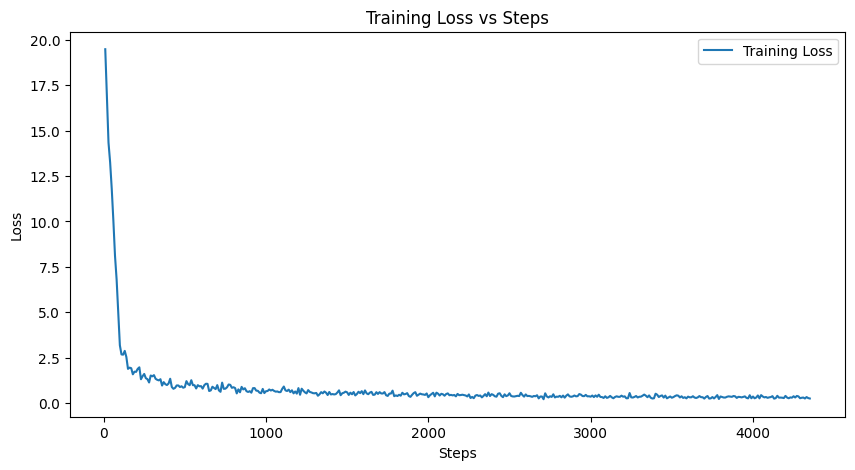

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

#device = torch.device('cpu')

# Import the data
data_import = load_dataset("coai/plantuml_generation")

def prepare_input(input_data):
    # Corrected regex to escape the pipe character
    segments = re.sub(r'\|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    # Extracting description and PlantUML code
    # The PlantUML code should already contain the correct newlines, so no need to replace spaces with newlines
    plantUML_code_with_newlines = segments[1].strip()
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': plantUML_code_with_newlines
    }


# Prepare the data array
prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

# Create a DataFrame from the prepared data array
data_frame = pd.DataFrame(prepared_data_array)

# Split the data into training and validation sets
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)


# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-large')

# Prepare the data for T5
def prepare_data_for_t5(batch):
    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=512)
    outputs = tokenizer(batch['plantUML_code'], padding='max_length', truncation=True, max_length=512)
    inputs['labels'] = outputs['input_ids']
    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results_new',
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_new',
    logging_strategy='steps',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()

In [ ]:
model.push_to_hub("debusaha/T5-large_plantumlcode", token = hugging_face_token)
tokenizer.push_to_hub("debusaha/T5-large_plantumlcode", token = hugging_face_token)

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/debusaha/T5-large_plantumlcode/commit/3dd1c732c202a112e48fee50e53d1f64aa42a431', commit_message='Upload tokenizer', commit_description='', oid='3dd1c732c202a112e48fee50e53d1f64aa42a431', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
def generate_plantuml_code(model, tokenizer, device, description, max_length=1024):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Manually truncate the output after '@enduml'
    end_index = plantuml_code.find('@enduml')
    if end_index != -1:
        plantuml_code = plantuml_code[:end_index + len('@enduml')]

    return plantuml_code

# Example description for inference
example_description = val_df['description'].iloc[1]

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=512)

# Print the generated PlantUML code
print(plantuml_code_generated)

<pad> @startuml package "Content Monetization for a Blogging Platform" <unk> [Blogger] [Reader] [Advertiser] [Content Management System] [Blog Post] [Advertiser] <unk>[Blogger] --> [Content Management System] [Reader] --> [Content Management System] [Advertiser] --> [Content Management System] [Blogger] --> [Content Management System] [Advertiser] --> [Blogger] [Content Management System] --> [Content Management System] [Blogger] --> [Content Management System] [Blogger] --> [Content Management System] [Blogger] --> [Content Management System] [Blogger] --> [Content Management System] [Blogger] --> [Advertiser] [Blogger] --> [Blogger] [Blogger] --> [Adverter] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Advertiser] [Blogger] --> [Blogger] [Blogger] --> [Blogger] [Blogger] --> [Bl

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer, Trainer, TrainingArguments
import torch
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

# Import the data
data_import = load_dataset("coai/plantuml_generation")

# Define a unique token for newlines
NEWLINE_TOKEN = '<n>'

def prepare_input(input_data):
    segments = re.sub(r'\|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    plantUML_code_with_newlines = segments[1].strip().replace('\n', NEWLINE_TOKEN)
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': plantUML_code_with_newlines
    }

# Prepare the data array
prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

# Create a DataFrame from the prepared data array
data_frame = pd.DataFrame(prepared_data_array)

# Split the data into training and validation sets
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)

# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-large')

# Prepare the data for T5
def prepare_data_for_t5(batch):
    # Replace newline characters with the NEWLINE_TOKEN
    batch['plantUML_code'] = batch['plantUML_code'].replace(NEWLINE_TOKEN, '\n')

    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=512)
    outputs = tokenizer(batch['plantUML_code'], padding='max_length', truncation=True, max_length=512)

    # Replace the NEWLINE_TOKEN back with the actual newline character
    outputs_decoded = [token.replace(NEWLINE_TOKEN, '\n') for token in outputs['input_ids']]
    inputs['labels'] = tokenizer(outputs_decoded, padding='max_length', truncation=True, max_length=512)['input_ids']

    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results_new',
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_new',
    logging_strategy='steps',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


AttributeError: 'int' object has no attribute 'replace'

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

#device = torch.device('cpu')

# Import the data
data_import = load_dataset("coai/plantuml_generation")

def prepare_input(input_data):
    # Corrected regex to escape the pipe character
    segments = re.sub(r'\|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    # Extracting description and PlantUML code
    # The PlantUML code should already contain the correct newlines, so no need to replace spaces with newlines
    plantUML_code_with_newlines = segments[1].strip()
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': plantUML_code_with_newlines
    }


# Prepare the data array
prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

# Create a DataFrame from the prepared data array
data_frame = pd.DataFrame(prepared_data_array)

# Split the data into training and validation sets
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)


# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-large')

# Prepare the data for T5
def prepare_data_for_t5(batch):
    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=1024)
    outputs = tokenizer(batch['plantUML_code'], padding='max_length', truncation=True, max_length=1024)
    inputs['labels'] = outputs['input_ids']
    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results_new',
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_new',
    logging_strategy='steps',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.190600,1.268083
2,1.023400,0.736197
3,0.703600,0.648687
4,0.571400,0.590965
5,0.482600,0.583401


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


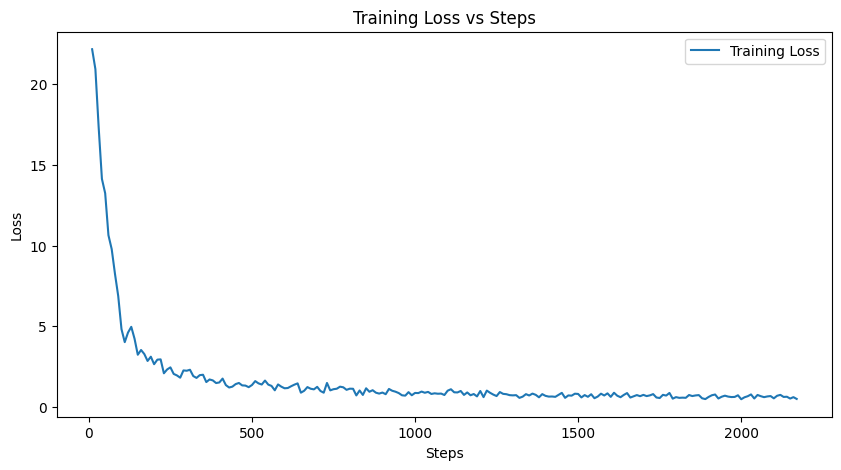

In [ ]:
import torch
import re
from datasets import load_dataset
from transformers import T5Tokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

# Import the data
data_import = load_dataset("coai/plantuml_generation")

# Define the prepare_input function
def prepare_input(input_data):
    # Corrected regex to escape the pipe character
    segments = re.sub(r'|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    # Extracting description and PlantUML code
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': segments[1].strip()
    }

# Prepare the data array
prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

# Create a DataFrame from the prepared data array
data_frame = pd.DataFrame(prepared_data_array)

# Split the data into training and validation sets
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)

# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-large')

# Add the newline token as a special token
tokenizer.add_tokens(['\n'])
model.resize_token_embeddings(len(tokenizer))

# Prepare the data for T5
def prepare_data_for_t5(batch):
    # Tokenize the description
    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=512)
    # Tokenize the PlantUML code, ensuring that '\n' is treated as a separate token
    outputs = tokenizer(batch['plantUML_code'].replace('\n', ' \n '), padding='max_length', truncation=True, max_length=512)
    # Set the labels for the model
    inputs['labels'] = outputs['input_ids']
    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if isinstance(idx, int):  # Handle single item
            return self.data[idx]
        elif isinstance(idx, slice):  # Handle slicing
            return [self.data[i] for i in range(*idx.indices(len(self)))]
        else:
            raise TypeError(f'Index must be an int or slice, not {type(idx)}')

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()


In [ ]:
def generate_plantuml_code(model, tokenizer, device, description, max_length=2048):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Manually truncate the output after '@enduml'
    end_index = plantuml_code.find('@enduml')
    if end_index != -1:
        plantuml_code = plantuml_code[:end_index + len('@enduml')]

    return plantuml_code

# Example description for inference
example_description = val_df['description'].iloc[15]

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=2048)

# Print the generated PlantUML code
print(plantuml_code_generated)

@startuml 
 [*] --> UserOpensPlatform 
 UserOpensPlatform --> UserLogsIn : User logs into account 
 UserLogsIn --> UserNavigatesToRequestService : User navigates to "Request Service" section 
 UserNavigatesToRequestService --> UserSelectsService : User selects type of service needed 
 UserSelectsAppointment --> UserReviewsServiceRequestDetails : User reviews service request details 
 UserReviewsServiceRequest --> PlatformSendsConfirmationEmail : Platform sends confirmation email 
 PlatformNotifyServiceProviders --> UserReceivesNotification : User receives notification of service providers' responses 
 UserReceivesConfirmsAppointment --> UserConfirmsAppointment : User selects based on availability and cost 
 UserRequestsPaint --> UserConfirmsAppointment : User and service provider communicates 
 UserRequestsPaint --> UserConfirmsAppointment : User and service provider communicate to finalizes appointment 
 UserRequestsPaint --> UserConfirmsAppointment : User and service provider communi

In [ ]:
def generate_plantuml_code(model, tokenizer, device, description, max_length=512):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Manually append '@enduml' if it's not present
    if '@enduml' not in plantuml_code:
        plantuml_code += '\n@enduml'

    return plantuml_code

# Example description for inference
example_description = val_df['description'].iloc[10]

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=512)

# Print the generated PlantUML code
print(plantuml_code_generated)


@startuml 
 left to right direction 
 actor Customer 
 actor WarehouseStaff 
 actor ShippingCarrier 
 
 rectangle "Order Fulfillment in E-commerce Supply Chain Management" 
 Customer --> (Place Order) 
 WarehouseStaff --> (Pick Products) 
 WarehouseStaff --> (Pick Products) 
 WarehouseStaff --> (Pick Products) 
 WarehouseStaff --> (Pack Products) 
 WarehouseStaff --> (Pack Products) 
 WarehouseStaff --> (Pack Products) 
 WarehouseStaff --> (Collect Packaged Products) 
 WarehouseStaff --> (Deliver Package) 
 WarehouseStaff --> (Confirm Order Delivery) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseStaff --> (Notify Customer) 
 WarehouseSta

In [ ]:
model.push_to_hub("debusaha/T5-large_plantumlcode_v2", token = hugging_face_token)
tokenizer.push_to_hub("debusaha/T5-large_plantumlcode_v2", token = hugging_face_token)

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/debusaha/T5-large_plantumlcode_v2/commit/2fd871e9709f14dab6822cd9e881de1ff1cb97c7', commit_message='Upload tokenizer', commit_description='', oid='2fd871e9709f14dab6822cd9e881de1ff1cb97c7', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import torch
torch.cuda.empty_cache()

!pip install numba
from numba import cuda
cuda.get_current_device().reset()


In [ ]:
device = torch.device('cuda')
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:290: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.491100,1.268083
2,1.143100,0.735160
3,0.708400,0.643394
4,0.893200,0.570203
5,0.625800,0.549397
6,0.530200,0.536497
7,0.278700,0.537364
8,0.255100,0.521077
9,0.308300,0.537753
10,0.374300,0.536153


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


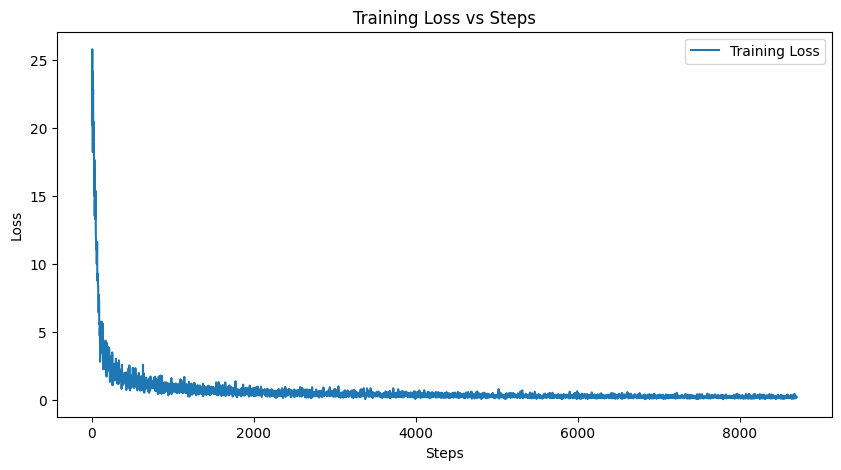

In [9]:
import torch
import re
from datasets import load_dataset
from transformers import T5Tokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Clear GPU cache
torch.cuda.empty_cache()

# Import the data
data_import = load_dataset("coai/plantuml_generation")

# Define the prepare_input function
def prepare_input(input_data):
    # Corrected regex to escape the pipe character
    segments = re.sub(r'|', '', input_data['text']).split('[/INST]')
    if len(segments) != 2 or '@startuml' not in segments[1] or '@enduml' not in segments[1]:
        return None
    # Extracting description and PlantUML code
    return {
        'description': re.split(r'@startuml', segments[0].replace('[INST]', '').strip(), maxsplit=1)[0].strip(),
        'plantUML_code': segments[1].strip()
    }

# Prepare the data array
prepared_data_array = [prepare_input(data) for data in data_import["train"] if prepare_input(data) is not None]

# Create a DataFrame from the prepared data array
data_frame = pd.DataFrame(prepared_data_array)

# Split the data into training and validation sets
train_df, val_df = train_test_split(data_frame, test_size=0.1, random_state=42)

# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-large')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-large')

# Add the newline token as a special token
tokenizer.add_tokens(['\n'])
model.resize_token_embeddings(len(tokenizer))

# Prepare the data for T5
def prepare_data_for_t5(batch):
    # Tokenize the description
    inputs = tokenizer(batch['description'], padding='max_length', truncation=True, max_length=512)
    # Tokenize the PlantUML code, ensuring that '\n' is treated as a separate token
    outputs = tokenizer(batch['plantUML_code'].replace('\n', ' \n '), padding='max_length', truncation=True, max_length=512)
    # Set the labels for the model
    inputs['labels'] = outputs['input_ids']
    return inputs

# Create a PyTorch dataset
class T5Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if isinstance(idx, int):  # Handle single item
            return self.data[idx]
        elif isinstance(idx, slice):  # Handle slicing
            return [self.data[i] for i in range(*idx.indices(len(self)))]
        else:
            raise TypeError(f'Index must be an int or slice, not {type(idx)}')

# Convert the dataframes to datasets
train_dataset = T5Dataset(train_df.apply(prepare_data_for_t5, axis=1).values.tolist())
val_dataset = T5Dataset(val_df.apply(prepare_data_for_t5, axis=1).values.tolist())

# Define the training arguments with additional parameters for saving the best model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=2,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,  # Limits the total amount of checkpoints, deletes the older checkpoints
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss to determine the best model
)

# Create the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Plotting training loss vs iterations
# You can retrieve the training loss from the trainer's state
loss_history = trainer.state.log_history

# Extract the loss values and their corresponding steps
steps = [entry['step'] for entry in loss_history if 'loss' in entry]
losses = [entry['loss'] for entry in loss_history if 'loss' in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs Steps')
plt.legend()
plt.show()


In [10]:
model.push_to_hub("debusaha/T5-large_plantumlcode_v3", token = hugging_face_token)
tokenizer.push_to_hub("debusaha/T5-large_plantumlcode_v3", token = hugging_face_token)

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/debusaha/T5-large_plantumlcode_v3/commit/867b65a3727821372cacec3d175c1869630c6c97', commit_message='Upload tokenizer', commit_description='', oid='867b65a3727821372cacec3d175c1869630c6c97', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
def generate_plantuml_code(model, tokenizer, device, description, max_length=512):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Manually append '@enduml' if it's not present
    if '@enduml' not in plantuml_code:
        plantuml_code += '\n@enduml'

    return plantuml_code

# Example description for inference
example_description = val_df['description'].iloc[25]

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=512)

# Print the generated PlantUML code
print(plantuml_code_generated)

@startuml 
 [*] --> UserRegistration 
 UserRegistration --> RegistrationPage : navigate to registration page 
 RegistrationPage --> UserInformation : enter personal information 
 UserInformation --> TermsAndConditions : agree to terms and conditions 
 RegistrationPage --> RegistrationButton : click "Register" button 
 RegistrationButton --> ValidateInformation : information is valid 
 ValidateInformation --> CreateAccount : create new user account 
 CreateAccount --> SendConfirmationEmail : create new user account 
 SendConfirmationEmail --> VerifyEmail : send confirmation email 
 VerifyEmail --> ActivateAccount : email address is verified 
 VerifyEmail --> ActivateAccount : email address is unique 
 VerifyEmail --> ActivateAccount : email address is already registered 
 ActivateAccount --> RedirectToLogin : user is redirected to login page 
 RedirectToLogin --> [*] 
 
 @enduml


In [20]:
plantuml_code = """
@startuml
 [*] --> UserRegistration
 UserRegistration --> RegistrationPage : navigate to registration page
 RegistrationPage --> UserInformation : enter personal information
 UserInformation --> TermsAndConditions : agree to terms and conditions
 RegistrationPage --> RegistrationButton : click "Register" button
 RegistrationButton --> ValidateInformation : information is valid
 ValidateInformation --> CreateAccount : create new user account
 CreateAccount --> SendConfirmationEmail : create new user account
 SendConfirmationEmail --> VerifyEmail : send confirmation email
 VerifyEmail --> ActivateAccount : email address is verified
 VerifyEmail --> ActivateAccount : email address is unique
 VerifyEmail --> ActivateAccount : email address is already registered
 ActivateAccount --> RedirectToLogin : user is redirected to login page
 RedirectToLogin --> [*]

 @enduml
"""
# Write the PlantUML code to a file
with open('diagram.puml', 'w') as file:
    file.write(plantuml_code)

In [21]:
from plantuml import PlantUML

# Create a PlantUML instance pointing to the local PlantUML server
plantuml = PlantUML(url='http://www.plantuml.com/plantuml/img/')

# Generate the diagram
plantuml.processes_file('diagram.puml')

True

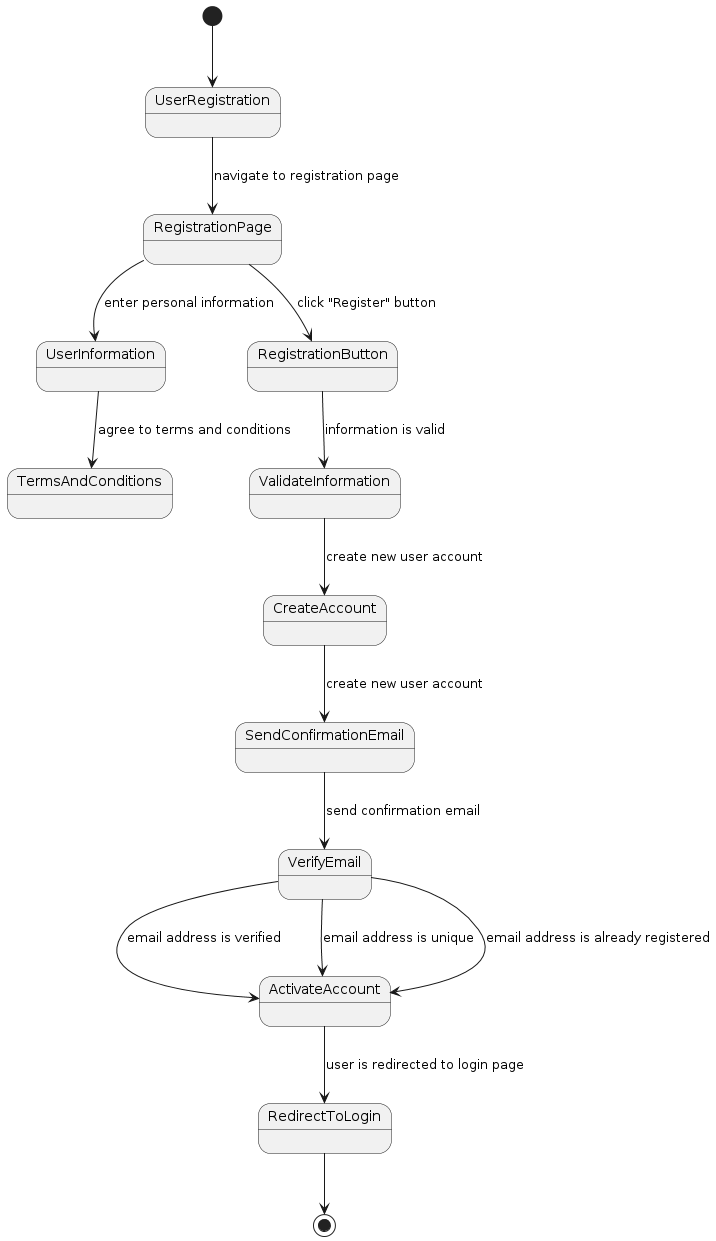

In [22]:
from IPython.display import Image, display

# Display the generated diagram
display(Image(filename='diagram.png'))

In [14]:
def generate_plantuml_code(model, tokenizer, device, description, max_length=1024):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

    # Generate the output token ids with a specified max_length
    output_ids = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=max_length)

    # Decode the token ids to get the PlantUML code
    plantuml_code = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Manually append '@enduml' if it's not present
    if '@enduml' not in plantuml_code:
        plantuml_code += '\n@enduml'

    return plantuml_code

# Example description for inference
example_description = val_df['description'].iloc[4]

# Run the inference with a specified max_length
plantuml_code_generated = generate_plantuml_code(model, tokenizer, device, example_description, max_length=1024)

# Print the generated PlantUML code
print(plantuml_code_generated)

@startuml 
 package "Secure Storage and Management of Cryptocurrency Assets" 
 [User] 
 [Wallet] 
 [Wallet Software] 
 [Hardware Wallet] 
 
 
 [User] --> [Wallet Software] 
 [Wallet Software] --> [Hardware Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet Hardware] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software] --> [Wallet] 
 [Wallet Software